In [ ]:
import numpy as np
from scipy.integrate.odepack import odeint
import matplotlib.pyplot as plt

In [2]:
import functions
from chondrocyte import Voltage_clamp
from params import params_dict

In [3]:
# define time span
params_dict["t_final"] = 100
t_final = params_dict["t_final"]
params_dict["dt"] = 1e-2
dt = params_dict["dt"]
t = np.linspace(0, t_final, int(t_final/dt))

In [4]:
# Define initial condition vector
y0 = (params_dict["V_0"], params_dict["Na_i_0"], params_dict["K_i_0"], params_dict["Ca_i_0"], params_dict["H_i_0"], 
      params_dict["Cl_i_0"], params_dict["a_ur_0"], params_dict["i_ur_0"], params_dict["vol_i_0"], 
      params_dict["cal_0"])

In [5]:
#solve the ODE system which is imported with chondrocyte
solution10 = odeint(functions.rhs, y0, t, args=(params_dict,))

In [6]:
VV, current10 = Voltage_clamp(solution10)

In [7]:
# update parameter
params_dict["Ca_i_0"] = 0.000175

In [8]:
solution175 = odeint(functions.rhs, y0, t, args=(params_dict,))

In [11]:
VV, current175 = Voltage_clamp(solution175)

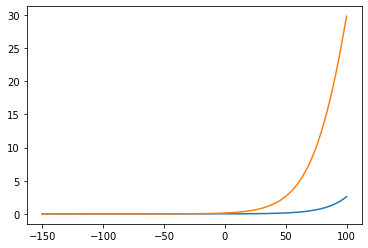

In [12]:
plt.plot(VV, current10["I_BK"])
plt.plot(VV, current175["I_BK"])